In [8]:
import matplotlib
import matplotlib.pyplot as plt                                                        
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'text.usetex': False})

# Hypothesis 
## 1. Noise is learned by layers nearer the output
Fine detail like noise is learned by later laters.  In other words, the outputs 
of earlier layers closer to the input do not contain much information about the 
noise in the output image.

### Reasoning
Fact 1: 
Receptive fields are larger for earlier layers.
For convolutional neural networks, the closer a layer is to the input 
the larger the the receptive field of that layer. So, earlier layers have larger
receptive fields.


I mixed up the concepts of layer outputs and layer kernels in how their effects
propagate through the network.

Incorrect assumption:  
After random initialization, neurons in earlier layers will _effect_ more output 
pixels than later layers.

This is true for the layer outputs, but _not_ necessarily true for the neurons 
in layer kernels (as all kernels are convolved with the previous layer output).

Example of how the reasoning is flawed:
I imagined a bias present in the last layer for every output pixel. This is not
true at all.There is an output activation for each output pixel, but not a 
weight or bias for each output pixel. 




## Argument 1
Consider a neuron N_first in the first layer and N_last in the last layer.

N_first will affect the value of more output pixels than N_last. (assumption 1)
If a neuron affects an output pixel, then that output pixel will effect the 
neuron's loss. (fact, I think)
Therefore, the loss for N_first will be affected by many more pixels than N_last.

## Argument 2
Consider a neuron N_first in the first layer and N_last in the last layer.

The loss for N_first will be affected by many more pixels than N_last. (arugment 1)
This would cause N_first to move towards a value that reduces the loss across
many pixels (and not just one).
This would cause resistance for N_first to encode noise for a single pixel.

(true at least at the beginning of training when weights are randomly 
initialized)

## 2. Higher-level features are learned in earlier layers
If there is a pressure for more noisy data to be learned by later layers, then
this implies that earlier layers will learn higher level features.

## 3. While higher-level features are being learned, noise cannot be effectively learned

## 4. So, later layers will need to wait for the stability of earlier layers before learning is effective.
Maybe this perspective is a bit more successful in the domain of image recognition?

If this were true, then it might explain DIP behaviour where noise is not 
learned at first.

# Experiment 1
For every training step, record a per-layer update distance. 

### Update distance measure
How far in weight space does a network layer update between steps?

This is calculated as a Euclidian distance 
$|weights_{after}  - weights_{before}|^2$, where the weights are all the weights
of a layer flattened into a single 1D vector.

```Python
layer_distances(loss, optimizer):
    '''Calculates a distance measure of whole layer updates between steps.
    
    Returns: (List[float]), List of layer update distances: 
                [layer1_dist, layer2_dist, ... layerN_dist]. 
    '''
    grads = optimizer.compute_gradients(loss)                                   
    # Replace gradients with step:                                              
    step_var_pairs = [(optimizer.mul_factor(v)*g,v) for g,v in grads]           
    # create the map: {layer: update_distance}
    layer_data = list(summarize_gradients_by_layer(step_var_pairs).values())
    return layer_data
```


In [2]:
import numpy as np
import csv
import pandas as pd
import pprint
import re
from collections import defaultdict

In [35]:
def layer_display_name(name):
    pattern = r'([a-z]+)(\d+)'
    m = re.search(pattern, name)
    assert m
    extra = name.split('_')
    name = m.group(1)
    layer_id = m.group(2)
    extra = f'({extra[1]})' if len(extra) == 2 else ''
    display_name = f'Layer {layer_id}: {name} {extra}'
    return  display_name
    
def display_results3(df, x_max, y_min=-3.5, y_max=3.0, win_size=20):
    # Font sizes
    title_font_size = 20
    x_axis_font_size = 18
    y_axis_font_size = 20
    sub_title_font_size = 18
    
    
    layer_names = df.columns.to_list()[2:]
    smooth_df = df.rolling(win_size, center=True, win_type='boxcar', min_periods=1).mean()
    fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(10,20), constrained_layout=True)
    #fig.subplots_adjust(top=10.0)
    fig.suptitle(f'Per-layer Euclidean update distance for each training step (mean smoothing, window size {win_size})', fontsize=title_font_size)
    #fig.tight_layout(h_pad=2)
    axes_f = axes.flatten()
    for i,layer_name in enumerate(layer_names):
        layer_id = i+1
        axes_f[i].set_title(f'{layer_display_name(layer_name)}', fontsize=sub_title_font_size)
        axes_f[i].plot(df.index, np.log10(smooth_df[f'{layer_name}'].values)) 
        axes_f[i].set_xlim(left=0, right=x_max)
        if i > 1:
            axes_f[i].set_xticklabels([])
        else:
            axes_f[i].set_xlabel('Training step', fontsize=x_axis_font_size)
        if i % 2:
            axes_f[i].set_yticklabels([])
        if i == 0:
            #axes_f[i].set_ylabel('$log_{10} \sum_{w \in layer} |w_n - w_{n-1}|^2$ ')
            axes_f[i].set_ylabel('Layer update distance ($log_{10}$)', fontsize=y_axis_font_size)
            
    # Disable the extra axes.
    axes_f[-1].set_axis_off()
    for a in axes_f:
        a.set_ylim(bottom=y_min, top=y_max)


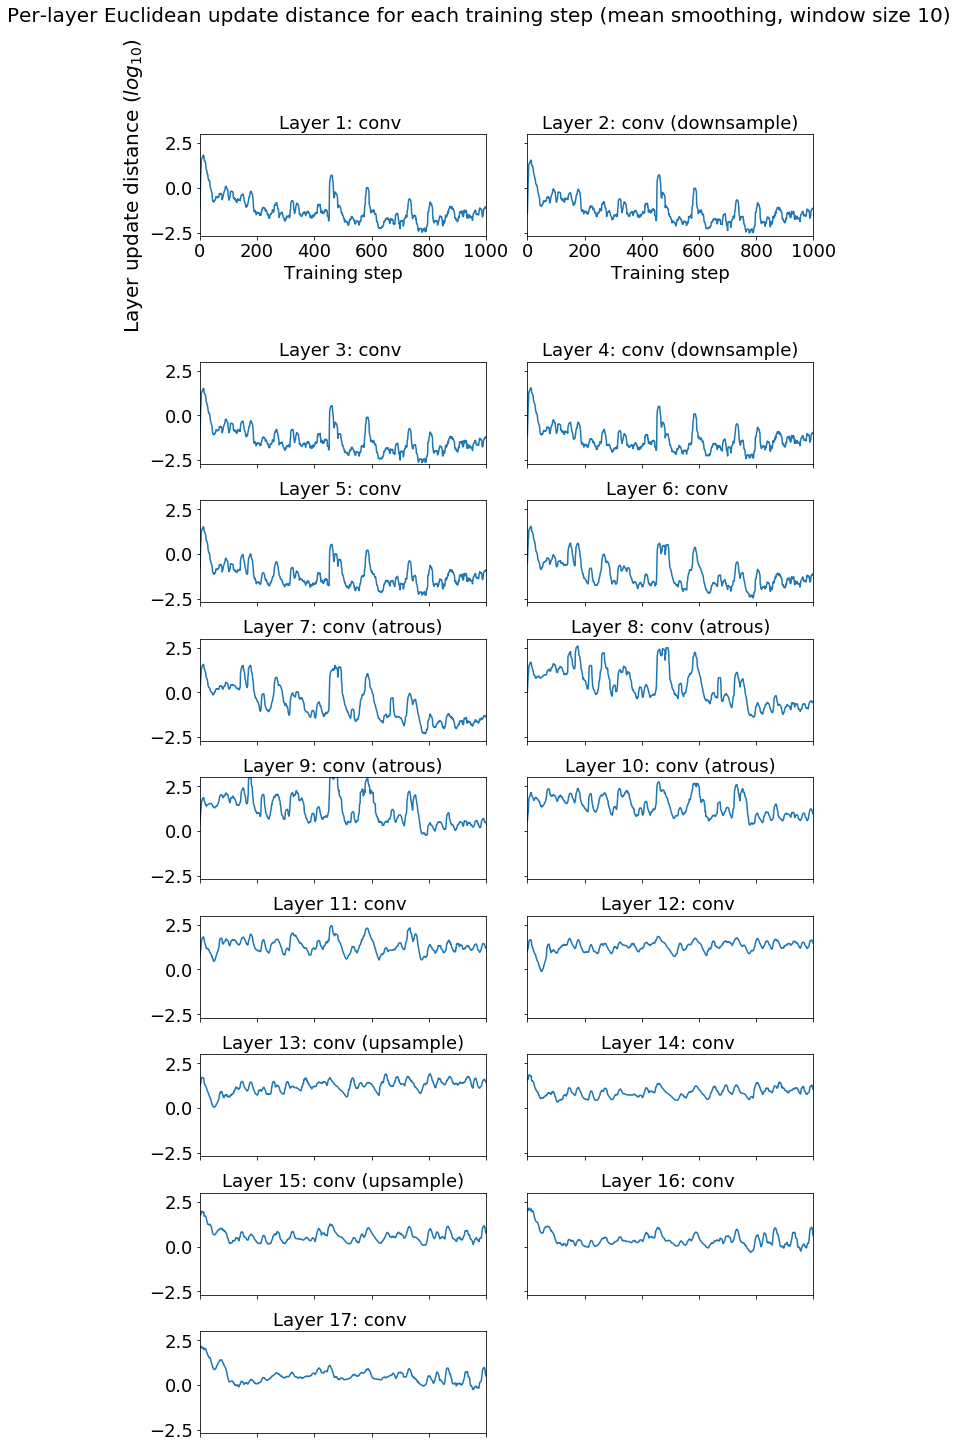

In [36]:
df = pd.read_pickle('../data/experiments/1/6/data.dataframe_pickle')
x_max = df.index.stop
# Best denoised image is ~400-600. 
x_max = 1000
smoothing_win = 10
display_results3(df, x_max, y_min=-2.7, y_max=3.0, win_size=smoothing_win)

import joypy
from matplotlib import cm
smooth_df = df.rolling(smoothing_win, center=True, win_type='boxcar', min_periods=1).mean()
data =  np.log10(smooth_df[df.columns.to_list()[2:]])

Note: atrous refers to dilated convolution. 

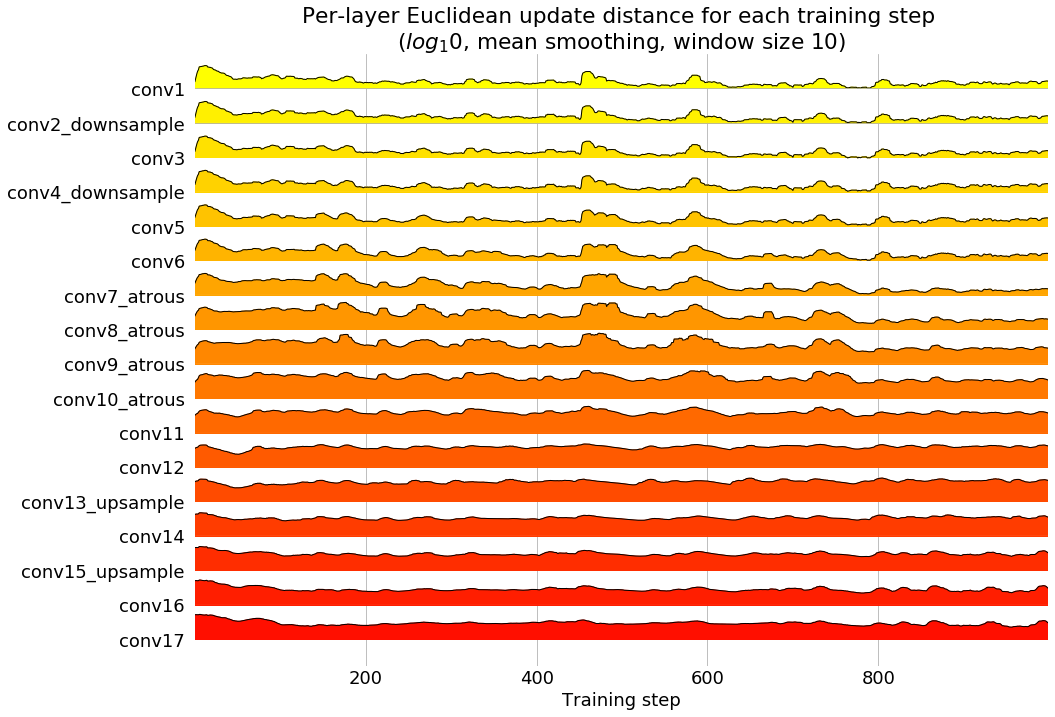

In [37]:
title = f'Per-layer Euclidean update distance for each training step \n' \
        f'($log_{10}$, mean smoothing, window size {smoothing_win})'
fig, axes = joypy.joyplot(
    2.5+data, 
    figsize=(15,10),
    title=title,
    colormap=cm.autumn_r,
    linewidth=1,
    overlap=0.3,
    grid='both',
    kind='values',
    x_range=range(0, x_max))
n = axes[-1].set_xlabel('Training step')

The color doesn't have any meaning. Just used to help visually distingish each layer.

# Experiment 2
The coarse distance might be hiding a lot of interesting dynamics. Try to look
at all the weights of a smaller model. 

## Data collection
For every step, record:
  * the value of every weight and layer output
  * the derivative of loss with respect to every weight and layer output
  * the update step for every weight

## Color range
The color range for the kernels uses the colormap 'PiYG' shown below.
The layer outputs/inputs uses a greyscale colormap.

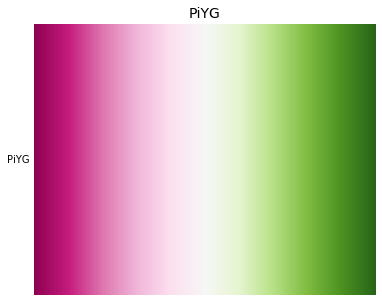

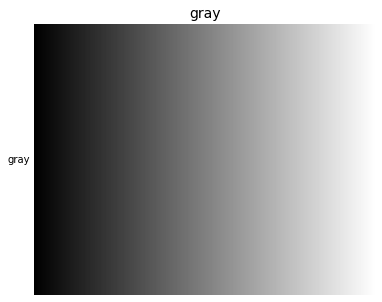

In [64]:
kernel_cmap = 'PiYG'
layer_cmap = 'gray'
nrows = 1
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

def plot_color_gradients(cmap_name, gradient):
    fig, axes = plt.subplots(nrows=1)
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
    axes.set_title(cmap_name, fontsize=14)

    axes.imshow(gradient, aspect='auto', cmap=cmap_name)
    pos = list(axes.get_position().bounds)
    x_text = pos[0] - 0.01
    y_text = pos[1] + pos[3]/2.
    fig.text(x_text, y_text, cmap_name, va='center', ha='right', fontsize=10)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    axes.set_axis_off()


plot_color_gradients(kernel_cmap, gradient)
plot_color_gradients(layer_cmap, gradient)
plt.show()

### Example kernel value bounds
The color range will be between the 5th and 95th precentile value.

![Example kernel value bounds](../out/experiments/2/6/network_vis/density.png)